In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

In [4]:
from src.VNET import custom_vnet

In [12]:
# the simulations can be generated by data_generation_nb notebook.
simulated_data = np.load('./generated_data/simulated_data_020124_150K.npy')

In [13]:
os.environ['PYTHONHASHSEED']=str(159)

np.random.seed(159)
tf.random.set_seed(159)

In [14]:
# Split the data
initial_state = simulated_data[:, 0]
final_state = simulated_data[:, 1]

# Compute the mean and std of the initial and final states
initial_state_mean, initial_state_std = np.mean(initial_state), np.std(initial_state)
final_state_mean, final_state_std = np.mean(final_state), np.std(final_state)

# Normalize the initial and final states
initial_state = (initial_state - initial_state_mean) / initial_state_std
final_state = (final_state - final_state_mean) / final_state_std

# Select one simulation's initial and final states
initial_conditions = initial_state[0]
final_density = final_state[0]

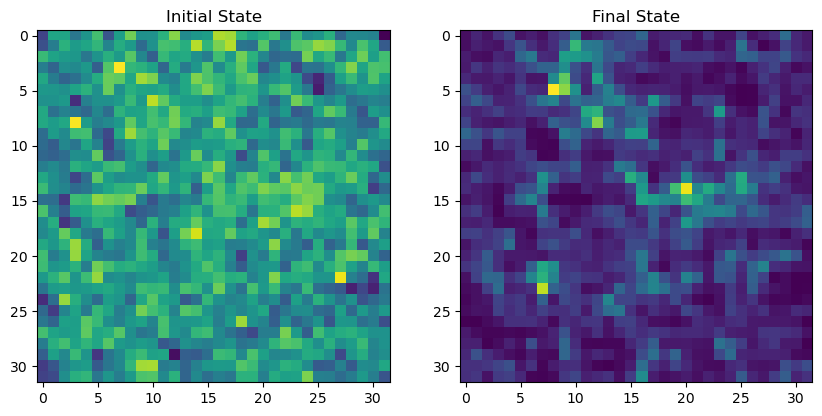

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# initial state and final state
axes[0].imshow(initial_conditions[0], cmap='viridis')
axes[0].set_title("Initial State")

axes[1].imshow(final_density[0], cmap='viridis')  
axes[1].set_title("Final State")

plt.show()

In [16]:
# train and test
X_train, X_test, y_train, y_test  = train_test_split(initial_state, final_state, test_size=0.15, random_state=123)

# further splitting it in training and testing
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=123)

In [17]:
# Recasting dimensions to 4D tensor (suitable for 3D convolutions) with the following dimensions: (batch_size, height, width, depth, num_channels)
X_train = np.reshape(X_train, (*X_train.shape, 1))
X_val = np.reshape(X_val, (*X_val.shape, 1))
X_test = np.reshape(X_test, (*X_test.shape, 1))

y_train = np.reshape(y_train, (*y_train.shape, 1))
y_val = np.reshape(y_val, (*y_val.shape, 1))
y_test = np.reshape(y_test, (*y_test.shape, 1))

In [18]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_test.shape, y_test.shape

((114750, 32, 32, 32, 1),
 (12750, 32, 32, 32, 1),
 (114750, 32, 32, 32, 1),
 (12750, 32, 32, 32, 1),
 (22500, 32, 32, 32, 1),
 (22500, 32, 32, 32, 1))

In [6]:
# saving in case the instance failed
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

## Instantiate VNet model

In [14]:
# Parameters
Ngrid = 32  # grid size

In [20]:
img_size = (Ngrid, Ngrid, Ngrid, 1)  # image size to use - (size_x, size_y, size_z, num_channels)
vnet = custom_vnet(img_size, output_activation='linear')

2024-01-02 14:30:46.251909: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-02 14:30:52.791944: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0


In [21]:
# Compile the model
vnet.compile(optimizer=Adam(), 
             loss='mse',
             run_eagerly=True)

In [22]:
checkpoint = ModelCheckpoint('vnet_model.h5', save_best_only=True)
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [23]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.reduce_sum(tf.random.normal([1000, 1000])))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
tf.Tensor(-1564.5986, shape=(), dtype=float32)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [24]:
history = vnet.fit(x=y_train, 
                   y=X_train, 
                   validation_data=(y_val, X_val), 
                   batch_size=32, 
                   epochs=50, 
                   callbacks=[checkpoint, early_stopping])

Epoch 1/50


2024-01-02 14:31:14.501266: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2024-01-02 14:31:31.972831: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3586/3586 [==============================] - 273s 69ms/step - loss: 0.4051 - val_loss: 0.3329
Epoch 2/50
3586/3586 [==============================] - 245s 68ms/step - loss: 0.3381 - val_loss: 0.9506
Epoch 3/50
3586/3586 [==============================] - 246s 69ms/step - loss: 0.3322 - val_loss: 0.3248
Epoch 4/50
3586/3586 [==============================] - 246s 69ms/step - loss: 0.3276 - val_loss: 0.3150
Epoch 5/50
3586/3586 [==============================] - 246s 69ms/step - loss: 0.3237 - val_loss: 0.3131
Epoch 6/50
3586/3586 [==============================] - 246s 68ms/step - loss: 0.3205 - val_loss: 0.3189
Epoch 7/50
3586/3586 [==============================] - 245s 68ms/step - loss: 0.3178 - val_loss: 0.3628
Epoch 8/50
3586/3586 [==============================] - 246s 69ms/step - loss: 0.3156 - val_loss: 0.3050
Epoch 9/50
3586/3586 [==============================] - 245s 68ms/step - loss: 0.3138 - val_loss: 210.4577
Epoch 10/50
3586/3586 [==============================] - 246s 69

In [7]:
# Load the arrays from .npy files in case the instance needs to be started from here.
y_test = np.load('y_test.npy')
X_test = np.load('X_test.npy')

In [8]:
# Load the model
# as the kernel was failing, the notebook was started from here again.
vnet = load_model('old_vnet_model_5K.h5')

In [25]:
eval_results = vnet.evaluate(x=X_test, y=y_test)
print(f"Evaluation Results:{eval_results}")

704/704 [==============================] - 16s 23ms/step - loss: 1.3929
Evaluation Results:1.3928664922714233


2024-01-02 15:45:50.693182: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 610.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-01-02 15:45:50.693262: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 610.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-01-02 15:45:50.697710: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-01-02 15:45:50.697733: W tensorflow/core/common_runtime/bfc_allocator.cc:275] A

In [8]:
predictions = vnet.predict(X_test)
predictions.shape

2024-01-02 16:21:02.125894: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


(22500, 32, 32, 32, 1)

In [9]:
np.min(predictions), np.min(X_test), np.max(predictions), np.max(X_test)

(-8.661757, -6.37655171866268, 3.7126834, 5.654421492301871)

In [10]:
vmin = min(np.min(predictions), np.min(X_test))
vmax = max(np.max(predictions), np.max(X_test))

vmin, vmax

(-8.661757, 5.654421492301871)

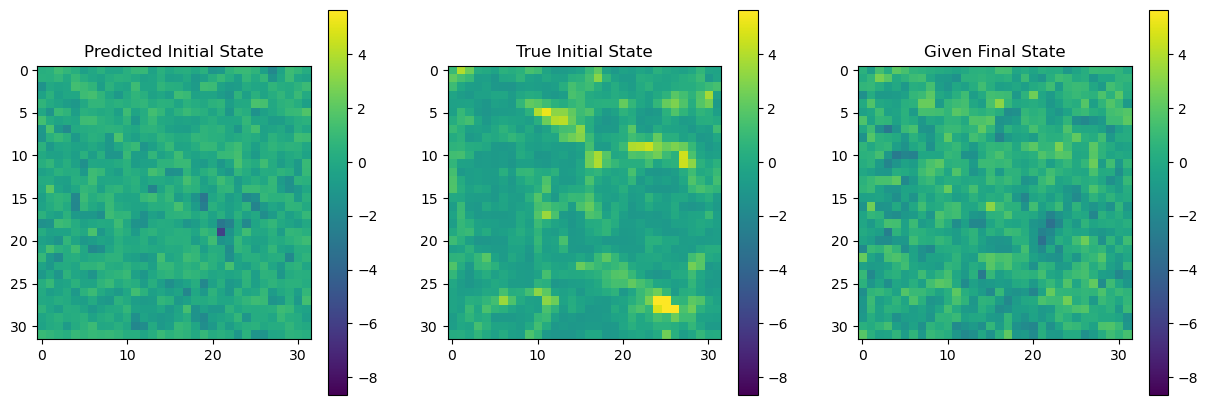

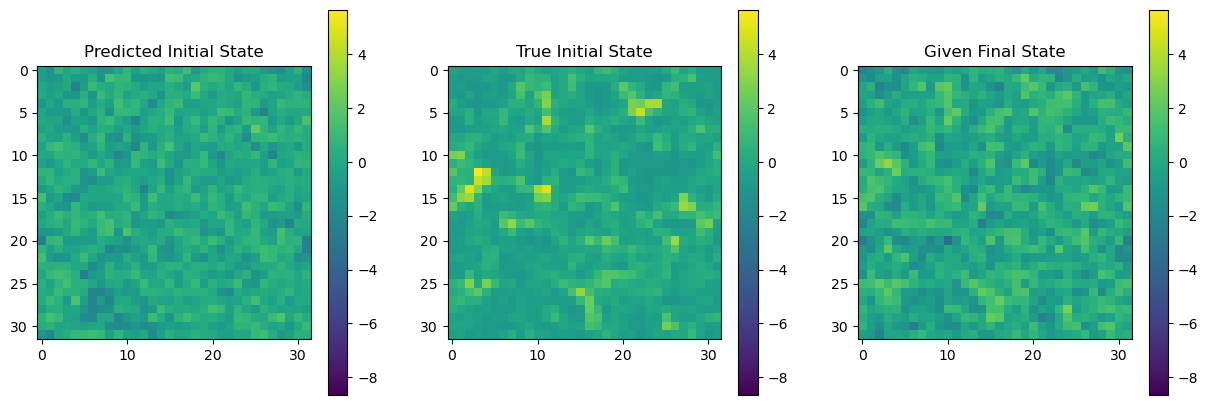

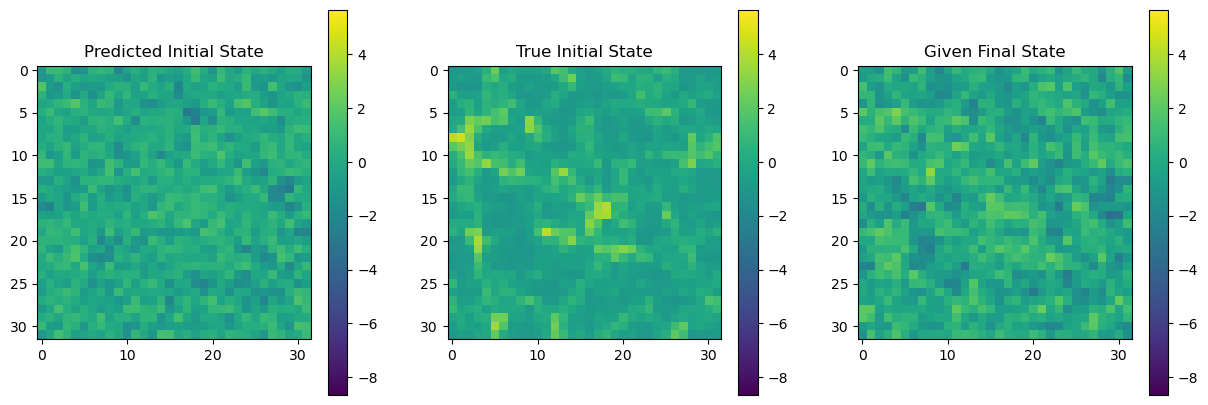

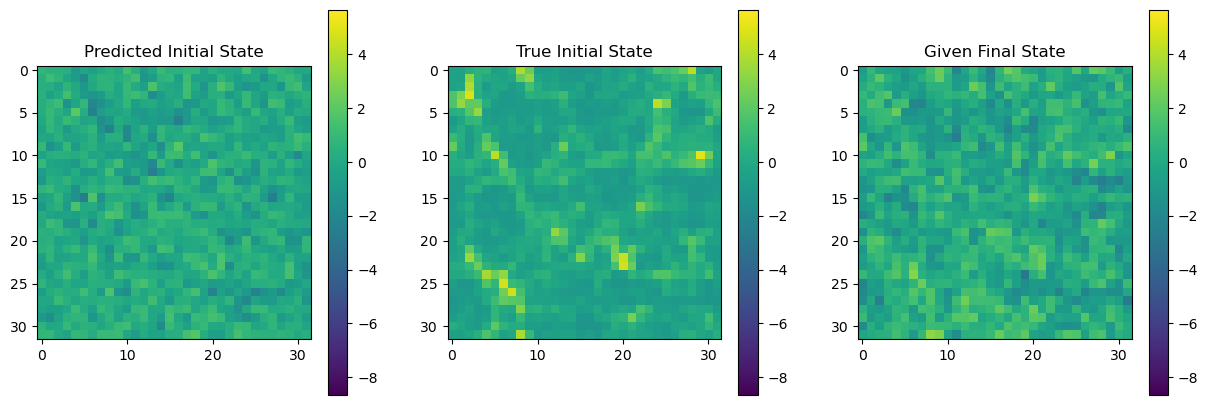

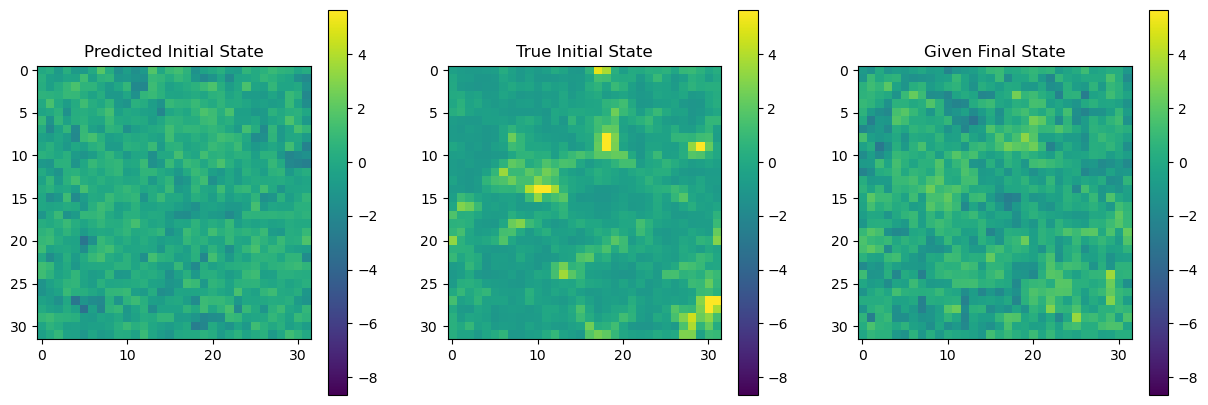

In [15]:
for test_index in range(5):  # Plot first 5 test cases
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot predicted initial state
    im = axs[0].imshow(predictions[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], vmin=vmin, vmax=vmax)
    axs[0].set_title('Predicted Initial State')
    fig.colorbar(im, ax=axs[0])

    # Plot true initial state
    im = axs[1].imshow(y_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], vmin=vmin, vmax=vmax)
    axs[1].set_title('True Initial State')
    fig.colorbar(im, ax=axs[1])

    # Plot given final state 
    im = axs[2].imshow(X_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], vmin=vmin, vmax=vmax)
    axs[2].set_title('Given Final State')
    fig.colorbar(im, ax=axs[2])

    plt.show()

In [18]:
# calculating the error metrics
mse = mean_squared_error(y_test.flatten(), predictions.flatten())
mae = mean_absolute_error(y_test.flatten(), predictions.flatten())

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 1.3928747213347303
Mean Absolute Error (MAE): 0.8897709465344144


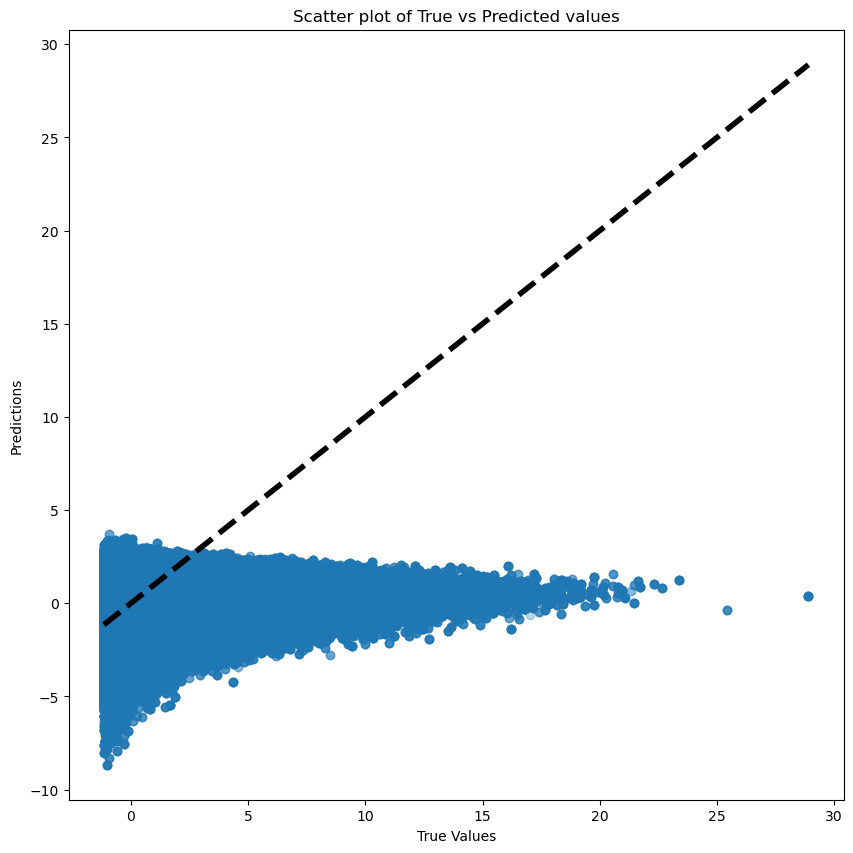

In [19]:
plt.figure(figsize=(10,10))
plt.scatter(y_test.flatten(), predictions.flatten(), alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Scatter plot of True vs Predicted values')
plt.show()

------
# Script Complete